# COGS 108 - Final Project (change this to your project's title)

# Overview

We investigated the existence of subcultures within Twitch chats using a set of six streamers. We wanted to see if there was any significant difference in language use between stream chat rooms. Although, our model's accuracy wasn't very high, it still performed fairly well for distinguishing between six categories. 

# Names

- Jianan Liu
- Casey Lee
- Mark Bussard
- Aryan Ziyar
- Hasan Liou

<a id='research_question'></a>
# Research Question

Of a subset of six Twitch streamers, can we reliably identify a particular streamer's chat by performing machine learning analyses on their respective chatlogs? Furthermore, does Twitch emote usage vary from streamer to streamer?

<a id='background'></a>

## Background & Prior Work

Twitch is currently one of the largest livestreaming platforms for games, where streamers play games and interact with viewers in real time. Emotes, one of Twitch's primary features, have been making their way into mainstream culture -- it is difficult to be in a conversation without "Poggers" or "sadge" finding its way in at least once. As a platform, however, Twitch "has not received much attention from the Natural Language Processing community" (Barbieri) despite its massive appeal and growing userbase.

Due to its massive popularity, major Twitch streams "act as virtual third places, in which informal communities emerge, socialize, and participate" (Hamilton). For instance, the chat for a streamer like Pokimane typically contains overbearing praise and support for the streamer, alongside ominiously generous donations. Meanwhile, loltyler1's chat embraces a culture of excessive toxicity, constantly berating the streamer in any way possible. Needless to say, the overall atmosphere of these Twitch chats vary greatly among streamers.

Emotes also play a large role in Twitch chat subcultures. As a way to react efficiently to the streamer, emotes have found their own specific meanings for various contexts (Barbieri). PogChamp is often used to express surprise and amazement, while ResidentSleeper is typically reserved for the when the audience is bored to tears. With this in mind, it follows that different emotes are probably preferred for different streams, as to fit with each unique subculture.

References (include links):

1) Hamilton, William A., Oliver Garretson, and Andruid Kerne. "Streaming on twitch: fostering participatory communities of play within live mixed media." Proceedings of the SIGCHI conference on human factors in computing systems. 2014. https://wrt205.afamiglietti.org/wp-content/uploads/2018/03/twitchtv.pdf 

2) Barbieri, Francesco, et al. "Towards the understanding of gaming audiences by modeling twitch emotes." Third Workshop on Noisy User-generated Text (W-NUT 2017); 2017 Sep 7; Copenhagen, Denmark. Stroudsburg (PA): ACL; 2017. p. 11-20.. ACL (Association for Computational Linguistics), 2017. https://repositori.upf.edu/bitstream/handle/10230/33289/Barbieri_NWUT2017_towa.pdf?sequence=1&isAllowed=y

# Hypothesis


We will likely find that Twitch chats are most likely to fall into either excessive admiration or derision, although still a simplified view of the culture. We predict that we will achieve some level of accuracy greater than randomness by creating a machine learning model that predicts Twitch streamers from any one chat message. Given prior knowledge on Twitch streams and emote usage, we suspect that the emotes PogChamp and LUL are likely to be evenly distributed among different chatrooms. These two, expressing surprise and laughter, are such common emotions that they will almost always appear. Twitch chats focused on toxicity and derision, on the other hand, will likely feature the ResidentSleeper and Kappa emotes more, since they represent boredom and trolling. Finally, overbearingly supportive streams will probably feature the heart and smiley emotes, for obvious reason.

# Dataset(s)

- Dataset Name: Twitch.tv Chat Log Data
- Dataset Link: https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/VE0IVQ
- Number of Observations: 2,162 Videos on Demand (VODs), 52 streamers

This dataset contains chatlog data from 2,162 VODs from 2018-4-24 to 2018-6-24, collected by Jeongmin Kim from the Korea Advance Institute of Science and Technology. This data was collected from scraping the Twitch website from various streamers, and are stored in Pickle (.pkl) files. The following observations are collected:

| Column Name      | Description |
| ----------- | ----------- |
| body      | Actual text for user chat       |
| channel_id   | Channel identifier (integer)        |
| commenter_id | User identifier (integer) |
| commenter_type | User type (character) |
| created_at | Time of when chat was entered (ISO 8601 date and time) |
| fragments | Chat text including parsing information of Twitch emote (JSON list) |
| offset | Time offset between start time of video stream and the time of when chat was entered (float) |
| updated_at | Time of when chat was edited (ISO 8601 date and time) |
| video_id | Video identifier (integer)  |

The bulk of our analysis will rely on body, fragments, offset, and updated_at, which represent the chat (text and emotes) and time sent in the video. This will give a sense of how messages become over time, and overall sentiment as the stream continues. Commenter_type will be used for data wrangling in removing bots from our dataset. Most identification data will be discarded, with the exception of the streamer. 

# Setup

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, precision_recall_fscore_support

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import twitch
import urllib
import json
import re

# Data Cleaning

First, we will read in each chatlog locally. To prevent any memory issues, we will be sampling 10,000 chatlogs from each streamer.

In [2]:
# Bring in subsamples of streamers
xqc = pd.read_pickle('Data/xqcow.pkl').sample(10000)
tim = pd.read_pickle('Data/timthetatman.pkl').sample(10000)
tyler1 = pd.read_pickle('Data/loltyler1.pkl').sample(10000)

qtpie = pd.read_pickle('Data/imaqtpie.pkl').sample(10000)
myth = pd.read_pickle('Data/tsm_myth.pkl').sample(10000)
ninja = pd.read_pickle('Data/ninja.pkl').sample(10000)

Next, we will make use of both the official and a 3rd party Twitch API to obtain ID's for every Global Twitch/BTTV Emote. First, we will utilize the Twitch Python API to get ID numbers of our streamers.

In [3]:
# Get Twitch API keys (stored locally)
with open('api_keys.json') as f:
    keys = json.load(f)

# Get channel ID's from our streamers
helix = twitch.Helix(keys['client_id'], keys['client_secret'])
streamers = ['xqcow', 'timthetatman', 'loltyler1', 'imaqtpie', 'myth', 'ninja']

# Get all streamer ID's
streamer_ids = [helix.user(s).data['id'] for s in streamers]

Then, we will generate a list of Twitch official global emotes, as well as BTTV emotes. For the purposes of this analysis, we will only be studying Twitch official emotes.

In [4]:
# Create list of Twitch official global emotes
with urllib.request.urlopen("https://api.twitchemotes.com/api/v4/channels/0") as url:
    requested = json.loads(url.read().decode())
emote_list = requested['emotes']

# match id's to emotes
id_emote = {}
for emote_dict in emote_list:
    id_emote[emote_dict['id']] = emote_dict['code']
id_list = [int(x['id']) for x in emote_list]

# Get global and channel specific BTTV emotes to throw out of our analysis
bttv_emotes = []
with urllib.request.urlopen("https://api.betterttv.net/3/cached/emotes/global") as url:
    requested = json.loads(url.read().decode())
bttv_emotes = [emote['code'].lower() for emote in requested]

for s in streamer_ids:
    with urllib.request.urlopen("https://api.betterttv.net/3/cached/users/twitch/" + s) as url:
        requested = json.loads(url.read().decode())
        streamer_emotes = [emote['code'].lower() for emote in requested['channelEmotes']]
    bttv_emotes += streamer_emotes

print("Twitch emote ID subset: " + str(id_list[:5]))
print("BTTV Emote subset: " + str(bttv_emotes[:5]))

Twitch emote ID subset: [12, 17, 10, 864205, 47]
BTTV Emote subset: [':tf:', 'cigrip', 'datsauce', 'foreveralone', 'gaben']


Twitch emote ID subset: [1, 2, 3, 4, 5]
BTTV Emote subset: [':tf:', 'cigrip', 'datsauce', 'foreveralone', 'gaben']

Here, we will create a new Pandas Series consisting of only Global Emotes.

In [5]:
# Emote function (take only one of each global emote, ignore rest)
def make_emote_list(x):
    lst = []
    # For each fragment
    for fragment in x:
        # Check that we have an emote fragment, and that it is a global emote
        if ('emoticon_id' in fragment.keys()) and (int(fragment['emoticon_id']) in id_list):
            # Add emote
            lst.append(int(fragment['emoticon_id']))
    
    # Save only unique emotes
    return list(set(lst))

# Apply function to dataset fragments
xqc['emotes'] = xqc.fragments.apply(make_emote_list)
tim['emotes'] = tim.fragments.apply(make_emote_list)
tyler1['emotes'] = tyler1.fragments.apply(make_emote_list)

qtpie['emotes'] = qtpie.fragments.apply(make_emote_list)
myth['emotes'] = myth.fragments.apply(make_emote_list)
ninja['emotes'] = ninja.fragments.apply(make_emote_list)

# Example output
test_fragments = [{'emoticon_id': '4'}, {'text': 'sample text'}, {'emoticon_id': '6'}]
print(make_emote_list(test_fragments))

[4, 6]


Finally, we will parse and clean the actual text of each chatlog. Any identifying information, URLs, and chat commands will be removed prior to analysis. Because these streamers speak only English on their channel, we will assume that all text is in English. First, we will extract text from our fragments.

In [6]:
# Take only text (no emotes)
def get_text_only(x):
    # Combines all elements in dict with "text" key
    text_str = " ".join([y['text'] for y in x if 'text' in y.keys()])
    
    # Removes trailing whitespaces and uppercase for analysis
    return text_str.lower().strip()

xqc['text_only'] = xqc.fragments.apply(get_text_only)
tim['text_only'] = tim.fragments.apply(get_text_only)
tyler1['text_only'] = tyler1.fragments.apply(get_text_only)

qtpie['text_only'] = qtpie.fragments.apply(get_text_only)
myth['text_only'] = myth.fragments.apply(get_text_only)
ninja['text_only'] = ninja.fragments.apply(get_text_only)

# Example output
print(get_text_only(test_fragments))

sample text


Next, we will use regex to filter out URLs and chat commands.

In [7]:
# Regex out URLs
regex_str = r'(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
xqc['text_only'] = xqc.text_only.str.replace(regex_str, '', regex=True)
tim['text_only'] = tim.text_only.str.replace(regex_str, '', regex=True)
tyler1['text_only'] = tyler1.text_only.str.replace(regex_str, '', regex=True)

qtpie['text_only'] = qtpie.text_only.str.replace(regex_str, '', regex=True)
myth['text_only'] = myth.text_only.str.replace(regex_str, '', regex=True)
ninja['text_only'] = ninja.text_only.str.replace(regex_str, '', regex=True)

# Example output
sample_text = 'check out https://github.com/COGS108/group013_sp21 for our project repo, or use !link'
sample_text = re.sub(regex_str, '', sample_text)

# Regex out commands
regex_str = r'\!\w+'

xqc['text_only'] = xqc.text_only.str.replace(regex_str, '', regex=True)
tim['text_only'] = tim.text_only.str.replace(regex_str, '', regex=True)
tyler1['text_only'] = tyler1.text_only.str.replace(regex_str, '', regex=True)

qtpie['text_only'] = qtpie.text_only.str.replace(regex_str, '', regex=True)
myth['text_only'] = myth.text_only.str.replace(regex_str, '', regex=True)
ninja['text_only'] = ninja.text_only.str.replace(regex_str, '', regex=True)

# Example Output
sample_text = re.sub(regex_str, '', sample_text)
print(sample_text)

check out  for our project repo, or use 


Identifying information from each streamer is removed.

In [8]:
# Remove identifying information
xqc_identifying_info = '|'.join(['@xqcow', 'xqcow', 'xqc'])
tim_identifying_info = '|'.join(['@timthetatman', 'timthetatman', 'tatman', 'tim'])
tyler1_identifying_info = '|'.join(['@loltyler1', 'loltyler1', 'tyler1', 'tyler'])

qtpie_identifying_info = '|'.join(['@imaqtpie', 'imaqtpie', 'qtpie', 'qt'])
myth_identifying_info = '|'.join(['@tsm_myth', '@myth', 'tsm_myth', 'myth'])
ninja_identifying_info = '|'.join(['@ninja', 'ninja'])

xqc['text_only'] = xqc.text_only.str.replace(xqc_identifying_info, '', regex=True)
tim['text_only'] = tim.text_only.str.replace(tim_identifying_info, '', regex=True)
tyler1['text_only'] = tyler1.text_only.str.replace(tyler1_identifying_info, '', regex=True)

qtpie['text_only'] = qtpie.text_only.str.replace(qtpie_identifying_info, '', regex=True)
myth['text_only'] = myth.text_only.str.replace(myth_identifying_info, '', regex=True)
ninja['text_only'] = ninja.text_only.str.replace(ninja_identifying_info, '', regex=True)

# Example Output
re.sub(xqc_identifying_info, '', 'i love you @xqcow please respond')

'i love you  please respond'

Finally, any BTTV emotes, stopwords, non-alphanumeric characters, and extra spaces are removed from our set. BTTV emotes are removed because some are channel specific and their associated ID's conflict with Twitch's emote ID's.

In [9]:
# Keep only alphanumeric characters
regex_str = r'\W'
xqc['text_only'] = xqc.text_only.str.replace(regex_str, ' ', regex=True)
tim['text_only'] = tim.text_only.str.replace(regex_str, ' ', regex=True)
tyler1['text_only'] = tyler1.text_only.str.replace(regex_str, ' ', regex=True)

qtpie['text_only'] = qtpie.text_only.str.replace(regex_str, ' ', regex=True)
myth['text_only'] = myth.text_only.str.replace(regex_str, ' ', regex=True)
ninja['text_only'] = ninja.text_only.str.replace(regex_str, ' ', regex=True)

# Example Output
example = re.sub(regex_str, ' ', 'oh man i need help!!! please @ me for help#!@!#!# karappa')
example

'oh man i need help    please   me for help        karappa'

In [10]:
# Stopwords + bttv emotes + extra spaces
sw = stopwords.words('english') + bttv_emotes

xqc['text_only'] = xqc['text_only'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw]))
tim['text_only'] = tim['text_only'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw]))
tyler1['text_only'] = tyler1['text_only'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw]))

qtpie['text_only'] = qtpie['text_only'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw]))
myth['text_only'] = myth['text_only'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw]))
ninja['text_only'] = ninja['text_only'].apply(lambda x: ' '.join([item for item in x.split() if item not in sw]))

example = ' '.join([item for item in example.split() if item not in sw])
example

'oh man need help please help'

# Data Analysis & Results

Before starting, we want to call to attention the existence of Twitch cultures -- from prior Twitch knowledge, we have learned that a running gag on loltyler1's stream is that he is an "Alpha male." To show that this running gag doesn't exist on other channels, we can observe the number of occurrences in each chat.

In [11]:
print('xqcOW: ' + str(len(xqc[xqc['body'].str.contains("alpha")])))
print('TimTheTatMan: ' + str(len(tim[tim['body'].str.contains("alpha")])))
print('loltyler1: ' + str(len(tyler1[tyler1['body'].str.contains("alpha")])))

print('imaqtpie: ' + str(len(qtpie[qtpie['body'].str.contains("alpha")])))
print('TSM_Myth: ' + str(len(myth[myth['body'].str.contains("alpha")])))
print('Ninja: ' + str(len(ninja[ninja['body'].str.contains("alpha")])))

xqcOW: 0
TimTheTatMan: 1
loltyler1: 18
imaqtpie: 3
TSM_Myth: 0
Ninja: 0


The frequency in which "alpha" appears in any one chat is close to 0, with tyler1's chat being the sole exception. With this in mind, we will explore the 10 most common words in each chat to observe whether we can identify a subculture within each chatroom.

In [12]:
# Get top unique words for every streamer
xqc_top = np.array(Counter(" ".join(xqc["text_only"]).split()).most_common(10))
tim_top = np.array(Counter(" ".join(tim["text_only"]).split()).most_common(10))
tyler1_top = np.array(Counter(" ".join(tyler1["text_only"]).split()).most_common(10))

qtpie_top = np.array(Counter(" ".join(qtpie["text_only"]).split()).most_common(10))
myth_top = np.array(Counter(" ".join(myth["text_only"]).split()).most_common(10))
ninja_top = np.array(Counter(" ".join(ninja["text_only"]).split()).most_common(10))

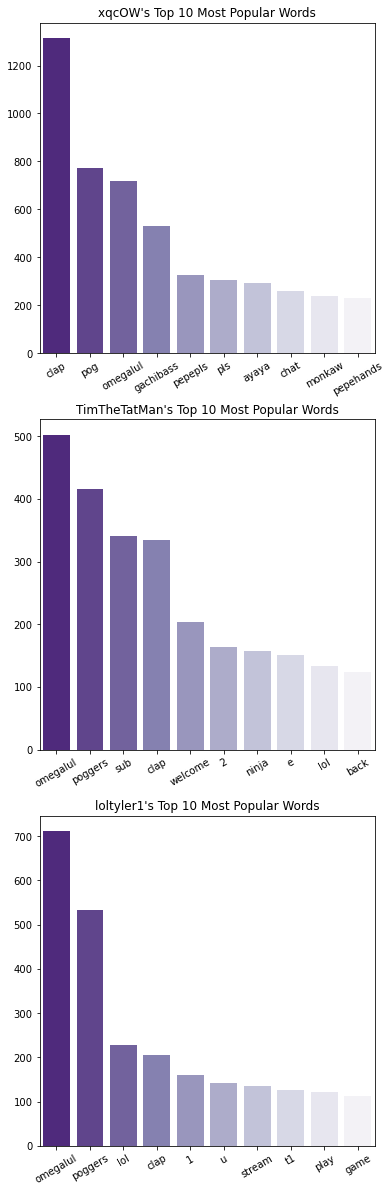

In [14]:
# Plot top 10 words in "funny" streams
plt.subplots_adjust(top = 4, bottom = 0.1)

plt.subplot(3, 1, 1)
ax = sns.barplot(x=xqc_top[:, 0], y=xqc_top[:, 1].astype(int), palette='Purples_r')
temp = ax.set_title("xqcOW's Top 10 Most Popular Words")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 2)
ax = sns.barplot(x=tim_top[:, 0], y=tim_top[:, 1].astype(int), palette='Purples_r')
temp = ax.set_title("TimTheTatMan's Top 10 Most Popular Words")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 3)
ax = sns.barplot(x=tyler1_top[:, 0], y=tyler1_top[:, 1].astype(int), palette='Purples_r')
temp = ax.set_title("loltyler1's Top 10 Most Popular Words")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

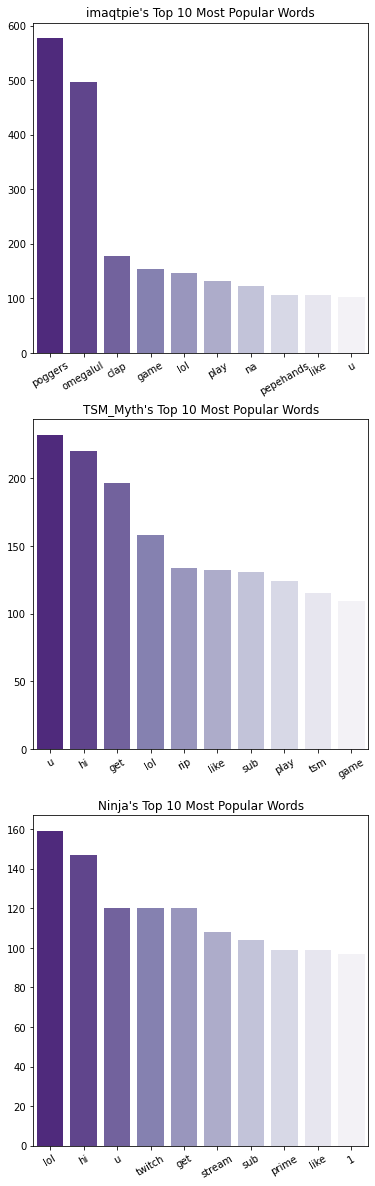

In [15]:
# Plot top 10 words in "serious streams"
plt.subplots_adjust(top = 4, bottom = 0.1)

plt.subplot(3, 1, 1)
ax = sns.barplot(x=qtpie_top[:, 0], y=qtpie_top[:, 1].astype(int), palette='Purples_r')
temp = ax.set_title("imaqtpie's Top 10 Most Popular Words")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 2)
ax = sns.barplot(x=myth_top[:, 0], y=myth_top[:, 1].astype(int), palette='Purples_r')
temp = ax.set_title("TSM_Myth's Top 10 Most Popular Words")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 3)
ax = sns.barplot(x=ninja_top[:, 0], y=ninja_top[:, 1].astype(int), palette='Purples_r')
temp = ax.set_title("Ninja's Top 10 Most Popular Words")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

Although there is some overlap, we can observe a fairly clear difference in the word choices between our two categories. Namely, we can see that our "fun" chatrooms have a preferred set of words, namely "omegalul" and "poggers", whereas "serious" chatrooms try to interact with the streamer with greetings, like "hi."

Interestingly, imaqtpie has a chatroom that seems more aligned with the "fun" streamers -- upon closer inspection, his content has shifted away from serious streams since his retirement from professional leagues.

Overall, there is clearly a difference in mood between these two categories. What about in terms of emote usage?

In [16]:
# Get top emotes in every stream chat
xqc_top_emotes = pd.Series(np.concatenate(xqc['emotes'].to_list()).ravel()).value_counts().iloc[:10].reset_index()
tim_top_emotes = pd.Series(np.concatenate(tim['emotes'].to_list()).ravel()).value_counts().iloc[:10].reset_index()
tyler1_top_emotes = pd.Series(np.concatenate(tyler1['emotes'].to_list()).ravel()).value_counts().iloc[:10].reset_index()

qtpie_top_emotes = pd.Series(np.concatenate(qtpie['emotes'].to_list()).ravel()).value_counts().iloc[:10].reset_index()
myth_top_emotes = pd.Series(np.concatenate(myth['emotes'].to_list()).ravel()).value_counts().iloc[:10].reset_index()
ninja_top_emotes = pd.Series(np.concatenate(ninja['emotes'].to_list()).ravel()).value_counts().iloc[:10].reset_index()

In [17]:
# Apply real emote name by ID
xqc_top_emotes['index'] = xqc_top_emotes['index'].apply(lambda x: id_emote[x])
tim_top_emotes['index'] = tim_top_emotes['index'].apply(lambda x: id_emote[x])
tyler1_top_emotes['index'] = tyler1_top_emotes['index'].apply(lambda x: id_emote[x])

qtpie_top_emotes['index'] = qtpie_top_emotes['index'].apply(lambda x: id_emote[x])
myth_top_emotes['index'] = myth_top_emotes['index'].apply(lambda x: id_emote[x])
ninja_top_emotes['index'] = ninja_top_emotes['index'].apply(lambda x: id_emote[x])

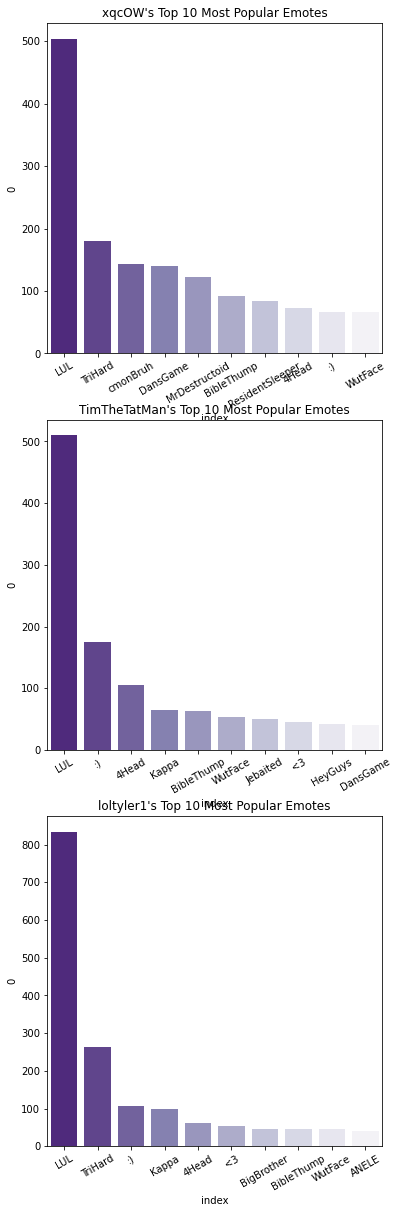

In [18]:
# Show top 10 emotes by fun streamers

plt.subplots_adjust(top = 4, bottom = 0.1)

plt.subplot(3, 1, 1)
ax = sns.barplot(x='index', y=0, data=xqc_top_emotes, palette='Purples_r')
temp = ax.set_title("xqcOW's Top 10 Most Popular Emotes")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 2)
ax = sns.barplot(x='index', y=0, data=tim_top_emotes, palette='Purples_r')
temp = ax.set_title("TimTheTatMan's Top 10 Most Popular Emotes")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 3)
ax = sns.barplot(x='index', y=0, data=tyler1_top_emotes, palette='Purples_r')
temp = ax.set_title("loltyler1's Top 10 Most Popular Emotes")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

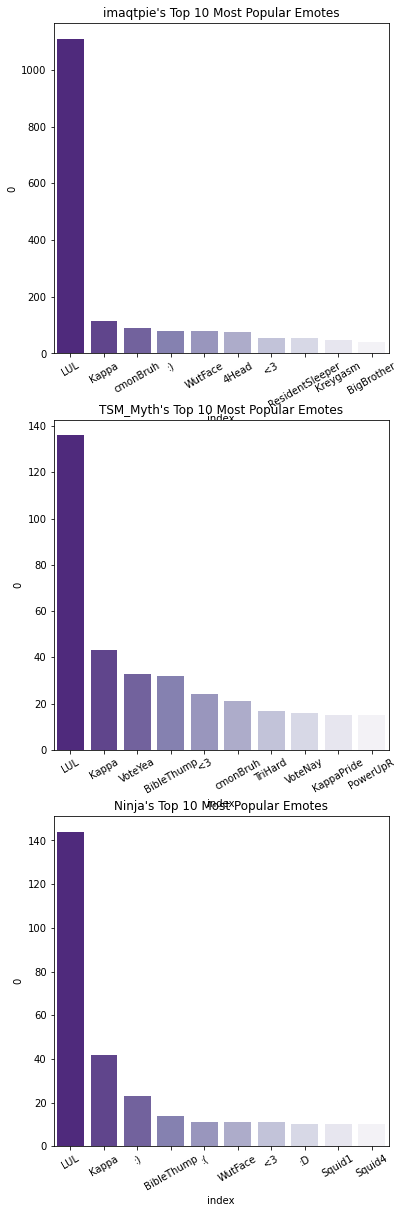

In [19]:
# Show top 10 emotes by serious streamers

plt.subplots_adjust(top = 4, bottom = 0.1)

plt.subplot(3, 1, 1)
ax = sns.barplot(x='index', y=0, data=qtpie_top_emotes, palette='Purples_r')
temp = ax.set_title("imaqtpie's Top 10 Most Popular Emotes")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 2)
ax = sns.barplot(x='index', y=0, data=myth_top_emotes, palette='Purples_r')
temp = ax.set_title("TSM_Myth's Top 10 Most Popular Emotes")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 3)
ax = sns.barplot(x='index', y=0, data=ninja_top_emotes, palette='Purples_r')
temp = ax.set_title("Ninja's Top 10 Most Popular Emotes")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

While more subtle, there is still a few notable differences in the emote preferences within each chatroom. LUL, an emote that indicates laughter, is by far the universally most popular emote amongst all streams. As we traverse down, however, we notice changes in preference. Ninja's chat, for instance, uses the Squid emotes for some reason. Meanwhile, PowerUpL and PowerUpR appear to be popular solely in TSM_Myth's stream.

Observing general popularity is a decent statistic, but we should also take into account the most unique words between chatrooms. To do so, we will observe term popularity with respect to the TF-IDF algorithm.

In [20]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=100, tokenizer=word_tokenize)

In [21]:
# Create "corpus" (list of strings) for vectorizer

text = []
text.append(' '.join(' '.join(xqc['text_only'].to_list()).split()))
text.append(' '.join(' '.join(tim['text_only'].to_list()).split()))
text.append(' '.join(' '.join(tyler1['text_only'].to_list()).split()))
text.append(' '.join(' '.join(qtpie['text_only'].to_list()).split()))
text.append(' '.join(' '.join(myth['text_only'].to_list()).split()))
text.append(' '.join(' '.join(ninja['text_only'].to_list()).split()))

In [22]:
# Create DataFrame of TF-IDF scores by streamer and word
streamers = ['xqcOW', 'TimTheTatMan', 'loltyler1', 'imaqtpie', 'TSM_Myth', 'Ninja']
twitch_tfidf = pd.DataFrame.sparse.from_spmatrix(tfidf.fit_transform(text), columns=tfidf.get_feature_names(), index=streamers)
twitch_tfidf

,0,1,10,2,3,4,5,7,ayaya,back,...,us,use,w,want,watch,welcome,win,would,wtf,yes
xqcOW,0.090480,0.102132,0.068385,0.112215,0.087008,0.085700,0.074030,0.120171,0.175013,0.088821,...,0.099301,0.066677,0.087631,0.077402,0.076341,0.000000,0.081986,0.068385,0.106096,0.092495
TimTheTatMan,0.091194,0.097667,0.070406,0.126392,0.099596,0.090492,0.087417,0.076832,0.027692,0.120431,...,0.095540,0.079426,0.099596,0.089765,0.096093,0.151094,0.105899,0.090492,0.079426,0.109335
loltyler1,0.094091,0.125483,0.087951,0.116386,0.110643,0.100615,0.103427,0.111423,0.098410,0.099282,...,0.085419,0.080356,0.095790,0.089482,0.104524,0.070228,0.086298,0.085419,0.099736,0.095790
imaqtpie,0.115222,0.119292,0.090950,0.114688,0.106954,0.104486,0.109513,0.095385,0.028546,0.099611,...,0.091757,0.099056,0.090113,0.090113,0.096680,0.089710,0.096043,0.100152,0.112706,0.108088
TSM_Myth,0.107735,0.111362,0.113107,0.109790,0.105459,0.088650,0.091921,0.080047,0.000000,0.104223,...,0.082546,0.097253,0.073943,0.094080,0.095407,0.058437,0.096040,0.091921,0.086804,0.113385
Ninja,0.065437,0.123831,0.097764,0.113161,0.116585,0.106271,0.108662,0.088757,0.000000,0.104702,...,0.068404,0.114594,0.068404,0.099197,0.092807,0.101124,0.096231,0.097011,0.082367,0.101814


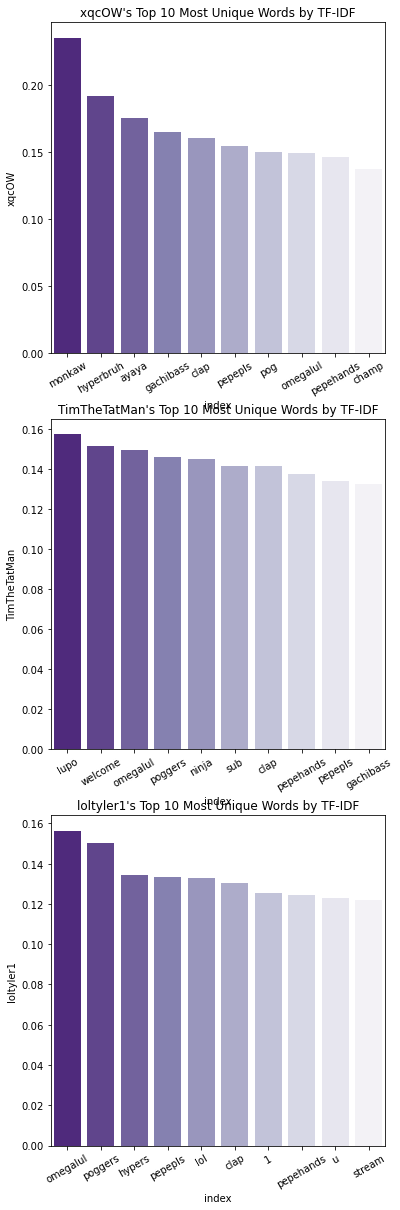

In [23]:
# Plot 10 highest scoring words for fun streamers
plt.subplots_adjust(top = 4, bottom = 0.1)

plt.subplot(3, 1, 1)
ax = sns.barplot(x='index', y='xqcOW', data=twitch_tfidf.loc['xqcOW'].nlargest(10).reset_index(), palette='Purples_r')
temp = ax.set_title("xqcOW's Top 10 Most Unique Words by TF-IDF")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 2)
ax = sns.barplot(x='index', y='TimTheTatMan', data=twitch_tfidf.loc['TimTheTatMan'].nlargest(10).reset_index(), palette='Purples_r')
temp = ax.set_title("TimTheTatMan's Top 10 Most Unique Words by TF-IDF")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 3)
ax = sns.barplot(x='index', y='loltyler1', data=twitch_tfidf.loc['loltyler1'].nlargest(10).reset_index(), palette='Purples_r')
temp = ax.set_title("loltyler1's Top 10 Most Unique Words by TF-IDF")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

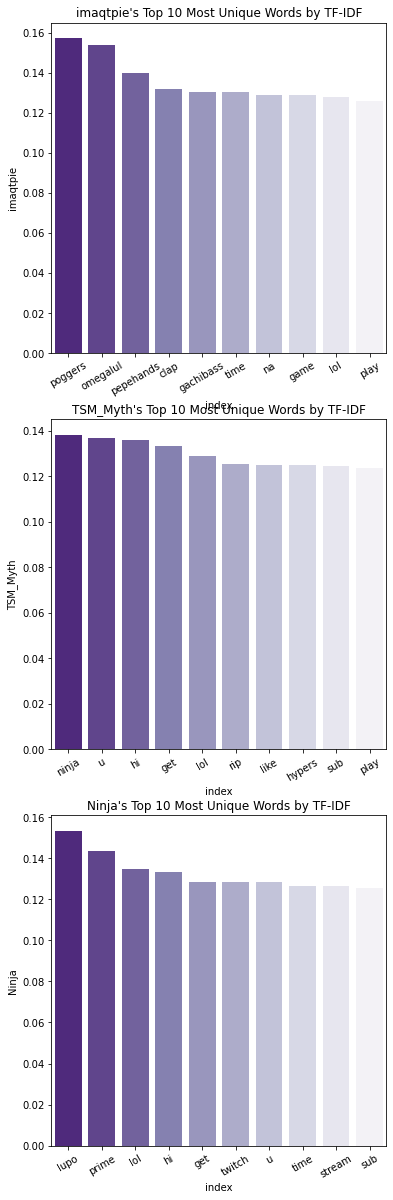

In [24]:
# Plot top 10 highest scoring words for serious streamers

plt.subplots_adjust(top = 4, bottom = 0.1)

plt.subplot(3, 1, 1)
ax = sns.barplot(x='index', y='imaqtpie', data=twitch_tfidf.loc['imaqtpie'].nlargest(10).reset_index(), palette='Purples_r')
temp = ax.set_title("imaqtpie's Top 10 Most Unique Words by TF-IDF")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 2)
ax = sns.barplot(x='index', y='TSM_Myth', data=twitch_tfidf.loc['TSM_Myth'].nlargest(10).reset_index(), palette='Purples_r')
temp = ax.set_title("TSM_Myth's Top 10 Most Unique Words by TF-IDF")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

plt.subplot(3, 1, 3)
ax = sns.barplot(x='index', y='Ninja', data=twitch_tfidf.loc['Ninja'].nlargest(10).reset_index(), palette='Purples_r')
temp = ax.set_title("Ninja's Top 10 Most Unique Words by TF-IDF")
temp = ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=30)

Again, while there is some overlap, many of the popular words between streams are fairly varied. Ninja's stream almost exclusively mentions "Twitch Prime," a subscription service in conjunction with Amazon Prime. Meanwhile, Ninja's name is brought up more in TSM_Myth and TimTheTatMan's stream than in anyone else's (since Ninja's identity was removed from his own chatroom). With how starkly different some of these chats are, we have the grounds to move forward with our classification algorithm.

In [25]:
tfidf = TfidfVectorizer(sublinear_tf=True, analyzer='word', max_features=2000, tokenizer=word_tokenize)

In [26]:
# Remove empty string ('') from text_only for each of the datasets
xqc_final = pd.Series([i for i in xqc['text_only'] if i]) 
tim_final = pd.Series([i for i in tim['text_only'] if i])
tyler1_final = pd.Series([i for i in tyler1['text_only'] if i])
qtpie_final = pd.Series([i for i in qtpie['text_only'] if i])
myth_final = pd.Series([i for i in myth['text_only'] if i])
ninja_final = pd.Series([i for i in ninja['text_only'] if i])

In [27]:
# Combine the 'text_only' columns from each of the streamers into one dataset with labels
xqc_frame = {'Chat Text': xqc_final}
xqc_result = pd.DataFrame(xqc_frame)
xqc_result['label'] = 'xqc'

tim_frame = {'Chat Text': tim_final}
tim_result = pd.DataFrame(tim_frame)
tim_result['label'] = 'tim'


tyler1_frame = {'Chat Text': tyler1_final}
tyler1_result = pd.DataFrame(tyler1_frame)
tyler1_result['label'] = 'tyler1'


qtpie_frame = {'Chat Text': qtpie_final}
qtpie_result = pd.DataFrame(qtpie_frame)
qtpie_result['label'] = 'qtpie'


myth_frame = {'Chat Text': myth_final}
myth_result = pd.DataFrame(myth_frame)
myth_result['label'] = 'myth'


ninja_frame = {'Chat Text': ninja_final}
ninja_result = pd.DataFrame(ninja_frame)
ninja_result['label'] = 'ninja'


frames = [xqc_result, tim_result, tyler1_result, qtpie_result, myth_result, ninja_result]
text_frame = pd.concat(frames)

In [28]:
# Shuffle the dataset
text_frame = text_frame.sample(frac=1, random_state=200).reset_index(drop=True)

tfidf_X = tfidf.fit_transform(text_frame['Chat Text']).toarray()

tfidf_Y = text_frame['label'].values
text_frame = text_frame.reset_index()

In [31]:
# Split the dataset
train_tfidf_X, test_tfidf_X, train_tfidf_Y, test_tfidf_Y = train_test_split(tfidf_X, tfidf_Y, test_size=0.2, random_state=200)

In [32]:
def train_SVM(X, y, kernel='linear'):
# YOUR CODE HERE
    clf = SVC(kernel=kernel)
    clf.fit(X, y)
    return clf

In [33]:
# Train the model
tfidf_clf = train_SVM(train_tfidf_X, train_tfidf_Y)

In [34]:
# Make predictions based on the model
prediction_train_tfidf_Y = tfidf_clf.predict(train_tfidf_X)
prediction_test_tfidf_Y = tfidf_clf.predict(test_tfidf_X)

In [35]:
# Assess the model with training data
print(classification_report(train_tfidf_Y, prediction_train_tfidf_Y))

              precision    recall  f1-score   support

        myth       0.35      0.73      0.47      6065
       ninja       0.56      0.32      0.41      4470
       qtpie       0.51      0.47      0.49      6139
         tim       0.54      0.37      0.44      5779
      tyler1       0.48      0.35      0.40      5968
         xqc       0.59      0.52      0.55      5883

    accuracy                           0.47     34304
   macro avg       0.50      0.46      0.46     34304
weighted avg       0.50      0.47      0.46     34304



In [36]:
# Assesss the model with test data
print(classification_report(test_tfidf_Y, prediction_test_tfidf_Y))

              precision    recall  f1-score   support

        myth       0.31      0.65      0.42      1556
       ninja       0.42      0.24      0.30      1141
       qtpie       0.44      0.39      0.41      1532
         tim       0.45      0.30      0.36      1424
      tyler1       0.39      0.30      0.34      1466
         xqc       0.54      0.46      0.50      1458

    accuracy                           0.40      8577
   macro avg       0.42      0.39      0.39      8577
weighted avg       0.42      0.40      0.39      8577



In [37]:
xqc_emote_final = pd.Series([i for i in xqc['emotes'] if i]) 
tim_emote_final = pd.Series([i for i in tim['emotes'] if i])
tyler1_emote_final = pd.Series([i for i in tyler1['emotes'] if i])
qtpie_emote_final = pd.Series([i for i in qtpie['emotes'] if i])
myth_emote_final = pd.Series([i for i in myth['emotes'] if i])
ninja_emote_final = pd.Series([i for i in ninja['emotes'] if i])

# Combine the 'text_only' columns from each of the streamers into one dataset with labels
xqc_emote_frame = {'Emote': xqc_emote_final}
xqc_result = pd.DataFrame(xqc_frame)
xqc_result['label'] = 'xqc'

tim_frame = {'Emote': tim_emote_final}
tim_result = pd.DataFrame(tim_frame)
tim_result['label'] = 'tim'


tyler1_frame = {'Emote': tyler1_emote_final}
tyler1_result = pd.DataFrame(tyler1_frame)
tyler1_result['label'] = 'tyler1'


qtpie_frame = {'Emote': qtpie_emote_final}
qtpie_result = pd.DataFrame(qtpie_frame)
qtpie_result['label'] = 'qtpie'


myth_frame = {'Emote': myth_emote_final}
myth_result = pd.DataFrame(myth_frame)
myth_result['label'] = 'myth'


ninja_frame = {'Emote': ninja_emote_final}
ninja_result = pd.DataFrame(ninja_frame)
ninja_result['label'] = 'ninja'


emote_frames = [xqc_result, tim_result, tyler1_result, qtpie_result, myth_result, ninja_result]
emote_frame = pd.concat(frames)


# Ethics & Privacy

Our biggest issue is userID -- while commenters are chatting in a public service, we cannot reasonably expect them to be aware that their chatlogs will be recorded and used for data analysis. UserIDs can be traced back to username and email, which borders the concern of protecting personally identifiable information. As such, the scope of our analysis will not focus on any one user, but rather the streamers themselves. Since all the streamers from this dataset are well-known household names among Twitch viewers, identifying trends on a per-streamer basis will not infringe upon any ethical violations.

Our data is constrained to a two month period so that we will only be analyzing the existing subcultures within that period. We hope that by constraining our period of study, that we are able to avoid bias since two months shouldn't give too much room for a chat subculture to evolve.

# Conclusion & Discussion

Compared to our hypothesis, our result shows us that through machine learning on the chatlogs for 6 streamers, we are able to identify streamers more accurately than random chance
We think the emotes are not as varied as we expected them to be. 
We are surprised that some streamers have similar characteristics regarding to word choices, but might not be categorized the same way by us for “serious” and “fun”
Some shortcomings are that our dataset does not contain the most recent data from the Twitch chatlogs. The dataset is from 2018 and the twitch community updates quickly so while our analysis works for the dataset, it may not scale to the current subculture in each streamers channel.
Currently we sampled 10,000 random data on each streamer, but the result of the machine learning could be better if we have more samples. However, the issue with more data is that it potentially would overload the computer and crash the kernel. 


# Team Contributions

As a team, we met every week during the quarter after the project was introduced and our group was formed. 
During those meetings, we utilized a modified form of pair programming, in which one person was the “driver” in which they typed out the code contained in the notebooks on github while the other 4 members of the group were “navigators” that dictated what the driver should type.
We found that this method reduced issues with git merging and facilitated an inclusive environment for group members to discuss and contribute content equally, regarding the final project. 
Overall, our group meetings were very productive and we were able to move forward with the checkpoints and proposals on a very timely basis due to these weekly meetings.